# PyQuil implementation of the data-driven quantum circuit learning (DDQCL) algorithm 

Authors: Vicente Leyton-Ortega and Alejandro Perdomo-Ortiz
Rigetti Computing

Not for distribution or for public release. If interested in using or sharing beyond this group of the 2018 CDL QML cohort, please send an email to alejandro@rigetti.com for permissions.

Summary: Quick (and probably highly suboptimal) implementation of DDQCL in pyQuil/Forest


In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
#load the necessary packages and libs 
from pyquil.quil import Program   
import pyquil.api as api
from pyquil.gates import *
import numpy as np
import matplotlib.pyplot as plt
from random import *
import itertools


qvm = api.QVMConnection()   # to use the virtual machine
PRECISION = 8
CLIP = 1e-8


## Bars & Stripes data set 

### Here we consider $n \times m$ data set

In [3]:
def bars_and_stripes(rows, cols):
    
    data = [] 
    
    for h in itertools.product([0,1], repeat=cols):
        pic = np.repeat([h], rows, 0)
        data.append(pic.ravel().tolist())
          
    for h in itertools.product([0,1], repeat=rows):
        pic = np.repeat([h], cols, 1)
        data.append(pic.ravel().tolist())
    
    data = np.unique(np.asarray(data), axis=0)
    
    return data

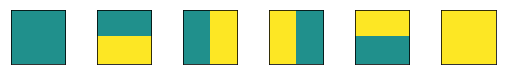

In [4]:
global n_qubits, hist_sample

n , m =  2, 2

bas = bars_and_stripes(n,m)

n_points, n_qubits  =  bas.shape

fig, ax = plt.subplots(1, bas.shape[0], figsize=(9,1))
for i in range(bas.shape[0]):
    ax[i].matshow(bas[i].reshape(n, m), vmin=-1, vmax=1)
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    
'''sample distribution'''
hist_sample = [0 for _ in range(2**n_qubits)]
for s in bas:
    b = ''.join(str(int(e)) for e in s)
    idx = int(b, 2)
    hist_sample[idx]  += 1./float(n_points) 

### Topologies 

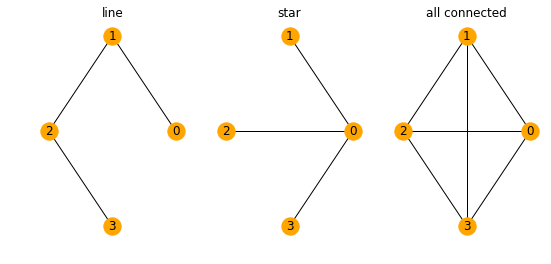

In [5]:
import networkx as nx 

edges_all_connected = []
edges_star          = []
edges_line          = []

''' line topology'''
for i in range(n_qubits-1):
    connections = [i,i+1]
    edges_line.append(connections)


'''star topology'''
for i in range(1,n_qubits):
    connections = [0,i]
    edges_star.append(connections)


'''all connected topology'''
for i in range(n_qubits-1):
    for j in range(i+1,n_qubits):
        connections = [i,j]
        edges_all_connected.append(connections)

# Or build any other you would like to explore. For example, ring topology?
        
        
'''lets define a little function for the connections'''
def top(x):
    if x == 0:
        edges = edges_line
    if x == 1: 
        edges = edges_star
    if x == 2:
        edges = edges_all_connected
    return edges

'''lets plot the different configuratios'''

options = {
           'node_color': 'orange',
           'node_size': 300,
           'width': 1}

fig =  plt.figure(figsize=(9,4))

graph_line = nx.Graph(top(0))
ax1 = fig.add_subplot(131)
ax1.set_title('line')
nx.draw_shell(graph_line, with_labels = True, **options)

graph_star = nx.Graph(top(1))
ax2 = fig.add_subplot(132)
ax2.set_title('star')
nx.draw_shell(graph_star, with_labels = True, **options)

graph_all_connected = nx.Graph(top(2))
ax3 = fig.add_subplot(133)
ax3.set_title('all connected')
nx.draw_shell(graph_all_connected,with_labels = True, **options)

### Circuit parameters

In [6]:
global n_top, single_g, entangling_g, n_layers, dimension
global min_bounds, max_bounds, n_rotations

'''define the topology'''
n_top = 2        # options: 0 - line, 1 - star,  2 - all connected 

'''define single and entangling gates'''
init_single_g =  ['RX','RZ']
single_g      =  ['RX','RZ','RY']
entangling_g  =  ['YY']       # options YY, ZZ, CPHASE -- the entangling gate can be modify in the circuit           

'''define the number of layers'''
n_layers = 2

'''angles'''
first_layer   = len(init_single_g)
n_rotations   = len(single_g)
even_n_layers = int(np.floor(n_layers/2))
odd_n_layers  = n_layers - even_n_layers
dimension     = (n_rotations*(odd_n_layers-1) + first_layer)*n_qubits + len(top(n_top))*even_n_layers #len(top(n_top)) is the number of edges in the graphs


### Circuit

In [7]:
def circuit(angles):
    
    C  = Program()
    for i in range(n_qubits):
        C.inst(I(i))           #here we are considering |00000000> as the input state. Options: Changing I to H applies Hadamards to all qubits and create a full superposition
    
   
    i = 0
#     for qb in range(n_qubits) :
#         for op in init_single_g: 
#             x = angles[i]*np.pi  #rotating angles are written in units of pi 
#             gate = (op + "("+str(x)+")",qb)
#             C.inst(gate)
#             i+=1                 #now it will call the next element in angles
    
#     for ly in range(2, n_layers + 1):
#         if ly % 2 == 1: #single gates are only in odd layers
#             for qb in range(n_qubits):
#                 for op in single_g:
#                     x = angles[i]*np.pi  #rotating angles are written in units of pi 
#                     gate = (op + "("+str(x)+")",qb)
#                     C.inst(gate)
                    
#                     i+=1                 #now it will call the next element in angles
                                        
#         else:
#             for qb_qb in top(n_top):
#                 if entangling_g[0] == 'YY':
                    
#                     x = angles[i]*np.pi/2.0 #entangling angles are written in units of 2*pi
#                     idx1 = qb_qb[0]
#                     idx2 = qb_qb[1]
                    
#                     C.inst(CNOT(idx1,idx2))
#                     C.inst(RY(2.0*x,idx2))
#                     C.inst(CNOT(idx1,idx2))
                            
#                     i+=1
                    
#                 elif entangling_g[0] == 'ZZ':  #ZZ(theta,1,2) = CNOT(1,2) RZ(2 theta,2) CNOT(1,2), - pi < 2 theta < pi
                    
#                     x = angles[i]*np.pi/2.0    # theta = x*pi/2, then -1 < x < 1
#                     idx1 = qb_qb[0]
#                     idx2 = qb_qb[1]
                    
#                     C.inst(CNOT(idx1,idx2))
#                     C.inst(RZ(2.0*x,idx2))
#                     C.inst(CNOT(idx1,idx2))
                    
#                     i+=1
                    
                    
#                                                ## we can define more entangling gates!
#                 else:
                    
#                     x = angles[i]*np.pi/2.0
#                     idx1 = qb_qb[0]
#                     idx2 = qb_qb[1]
#                     gate = (entangling_g[0] + "("+str(x)+")",idx1,idx2)
#                     C.inst(gate)
                    
#                     i+=1


    xx=[]
    for i in range(len(angles)):
        xx.append(angles[i]*np.pi/2.0)
    
    C.inst(RZ(2*xx[0],0)).inst(RZ(2*xx[1],1)).inst(RZ(2*xx[2],2)).inst(RZ(2*xx[3],3))
    C.inst(RY(2*xx[4],0)).inst(RY(2*xx[5],1)).inst(RY(2*xx[6],2)).inst(RY(2*xx[7],3))
    C.inst(RZ(2*xx[8],0)).inst(RZ(2*xx[8],1)).inst(RZ(2*xx[9],2)).inst(RZ(2*xx[10],3))    

#     C.inst(CNOT(1,2)).inst(RZ(2*xx[1],2)).inst(CNOT(1,2))    

#     for i in range(len(angles)):
#         x = angles[i]*np.pi/2.0
#         C.inst(RZ(2*x,i//4))
#         C.inst(RY(2*x,i//4))
    
#     C.inst(CZ(0,1))    

#     for i in range(len(angles)):
#         x = angles[i]*np.pi/2.0
#         C.inst(RZ(2*x,i//4))
#         C.inst(RY(2*x,i//4))
    
#     C.inst(CZ(0,1))

#     for i in range(len(angles)):
#         x = angles[i]*np.pi/2.0
#         C.inst(RZ(2*x,i//4))
#         C.inst(RY(2*x,i//4))

#     C.inst(CZ(1,2))

#     for i in range(len(angles)):
#         x = angles[i]*np.pi/2.0
#         C.inst(RZ(2*x,i//4))
#         C.inst(RY(2*x,i//4))

#     C.inst(CZ(2,3))

#     for i in range(len(angles)):
#         x = angles[i]*np.pi/2.0
#         C.inst(RZ(2*x,i//4))
#         C.inst(RY(2*x,i//4))
        
    
    qvm        =  api.QVMConnection()                
    wf         =  qvm.wavefunction(C)     #get the output circuit wavefunction
    probs_dist =  wf.get_outcome_probs()  #get the probability distribution --- be careful it is a dict
    probs      =  list(range(2**n_qubits))
    
    '''here we extract the distribution values from the dict'''
    for i in range(2**n_qubits):

        aa = str(np.binary_repr(i,n_qubits))[::-1]
        probs[i]=probs_dist[aa]
        
    assert(round(sum(probs), PRECISION)==1.)  # just to make sure 
    
    return (probs, C)
                    
                

### Kleiber - Leibler function

In [8]:
def KL(angles):
    probs, C = circuit(angles)
    
    l = 0.0
    for idx in range(2**n_qubits):
        l += -hist_sample[idx] * np.log(np.clip(probs[idx], CLIP, 1.)) \
                 + hist_sample[idx] * np.log(np.clip(hist_sample[idx], CLIP, 1.))    
    return l

In [9]:
def f(x):
    n_particles = x.shape[0]
    j = [KL(x[i]) for i in range(n_particles)]
    return np.array(j)

In [10]:
# circuit(list(range(16)))

In [11]:
import pyswarms as ps

In [12]:
# Initialize swarm
options = {'c1': 0.5, 'c2': 0.3, 'w':0.9}

# Call instance of PSO
optimizer = ps.single.GlobalBestPSO(n_particles=10, dimensions=16, options=options)

# Perform optimization
cost, pos = optimizer.optimize(f, print_step=1, iters=20, verbose=3)

INFO:pyswarms.single.global_best:Iteration 1/20, cost: 3.050145358008529
INFO:pyswarms.single.global_best:Iteration 2/20, cost: 2.0398346515837424
INFO:pyswarms.single.global_best:Iteration 3/20, cost: 1.8708423317254097
INFO:pyswarms.single.global_best:Iteration 4/20, cost: 1.8708423317254097
INFO:pyswarms.single.global_best:Iteration 5/20, cost: 1.8708423317254097
INFO:pyswarms.single.global_best:Iteration 6/20, cost: 1.8708423317254097
INFO:pyswarms.single.global_best:Iteration 7/20, cost: 1.8708423317254097
INFO:pyswarms.single.global_best:Iteration 8/20, cost: 1.7946289590553235
INFO:pyswarms.single.global_best:Iteration 9/20, cost: 1.5013401706330038
INFO:pyswarms.single.global_best:Iteration 10/20, cost: 1.5002825580898165
INFO:pyswarms.single.global_best:Iteration 11/20, cost: 1.3854068111633542
INFO:pyswarms.single.global_best:Iteration 12/20, cost: 1.3388091815018501
INFO:pyswarms.single.global_best:Iteration 13/20, cost: 1.3388091815018501
INFO:pyswarms.single.global_best:It

In [13]:
result, P = circuit(pos)

In [14]:
list(zip(result, hist_sample))

[(0.04603406793113384, 0.16666666666666666),
 (0.045851335509126054, 0),
 (0.04395323585395675, 0),
 (0.04377876330343855, 0.16666666666666666),
 (0.05813595525627431, 0),
 (0.057905184342749834, 0.16666666666666666),
 (0.05550809363180175, 0),
 (0.05528775402580504, 0),
 (0.06722357937250838, 0),
 (0.06695673509767375, 0),
 (0.06418493893538177, 0.16666666666666666),
 (0.06393015655626137, 0),
 (0.08489597331292134, 0.16666666666666666),
 (0.08455897839764719, 0),
 (0.08105850527170966, 0),
 (0.08073674320160998, 0.16666666666666666)]

In [15]:
from pyquil.api import CompilerConnection, get_devices

In [16]:
devices = get_devices(as_dict=True)
agave = devices['8Q-Agave']
compiler = CompilerConnection(agave)

job_id = compiler.compile_async(P)
job = compiler.wait_for_job(job_id)

# compiled_program = job.compiled_quil()
print(job.gate_volume())

job rwMuzPEmfwtlYykh is currently compiling
20


In [17]:
def is_unitary(ar):
    return np.allclose(np.eye(len(ar)), ar.dot(ar.T.conj()))

In [18]:
# ar = np.zeros((16,16))
ar = np.identity(16)
init = np.zeros(16)
init[0] = 1

for i in [0,3,5,10,12,15]:
    ar[i,0] = 1
#     ar[0,i] = 1
ar
# print(is_unitary(ar))
# np.allclose(np.eye(len(ar)), ar.dot(ar.T.conj()))
(np.linalg.inv(ar)).astype(int)
q, r = np.linalg.qr(ar)
print(is_unitary(q))
q.astype(int)

True


array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [19]:
target = np.zeros(16)
for i in [0,3,5,10,12,15]:
    target[i] = 1
target

array([1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1.])

In [20]:
np.dot(ar,init)

array([1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1.])

In [21]:
# First we define the new gate from a matrix
p = Program().defgate("AWE", q)

# Then we can use the new gate,
p.inst(("AWE", 0, 1, 2, 3))
print(p)

DEFGATE AWE:
    -0.40824829046386313, 0, 0, 0.1825741858350554, 0, 0.22360679774997907, 0, 0, 0, 0, 0.28867513459481275, 0, 0.408248290463863, 0, 0, -0.7071067811865477
    0, 1.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0
    0, 0, 1.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0
    -0.4082482904638631, 0, 0, -0.9128709291752769, 0, 1.1822020118747827e-17, 0, 0, 0, 0, 1.7725336915461842e-17, 0, 3.2115766228693264e-17, 0, 0, -5.906245609018999e-17
    0, 0, 0, 0, 1.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0
    -0.4082482904638631, 0, 0, 0.18257418583505539, 0, -0.8944271909999161, 0, 0, 0, 0, 3.847549107647386e-18, 0, 1.8237978420878807e-17, 0, 0, -3.551304858932161e-18
    0, 0, 0, 0, 0, 0, 1.0, 0, 0, 0, 0, 0, 0, 0, 0, 0
    0, 0, 0, 0, 0, 0, 0, 1.0, 0, 0, 0, 0, 0, 0, 0, 0
    0, 0, 0, 0, 0, 0, 0, 0, 1.0, 0, 0, 0, 0, 0, 0, 0
    0, 0, 0, 0, 0, 0, 0, 0, 0, 1.0, 0, 0, 0, 0, 0, 0
    -0.4082482904638631, 0, 0, 0.18257418583505539, 0, 0.22360679774997905, 0, 0, 0, 0, -0.8660254037844384, 0, 1.8237978

In [22]:
JOB_id = compiler.compile_async(p)
JOB = compiler.wait_for_job(JOB_id)

compiled_program = JOB.compiled_quil()
print(JOB.gate_volume())

job KOoPEBPKoOezXsuP is currently compiling
1313


In [23]:
JOB.gate_volume()

1313